In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import pickle
import torch
import torch.nn.functional as F

In [2]:
# Get the CLIP model
CLIP_PATH = "/Users/mustafaomergul/Desktop/Cornell/Research/tangrams-compgen/similarity_files/clip_model0_similarities.pkl"
with open(CLIP_PATH, 'rb') as f:
    clip_model = pickle.load(f)
    
IMAGE_DIR = '/Users/mustafaomergul/Desktop/Cornell/Research/tangrams-compgen/kilogram/square-black-imgs'
SPLIT_DIR = '/Users/mustafaomergul/Desktop/Cornell/Research/tangrams-compgen/split_info/stage_one_splits/'

In [3]:
# Sample from the distribution without replacement
def sample_without_replacement(distribution, K):
    new_distribution = torch.clone(distribution)

    samples = []
    for i in range(K):
        current_sample = torch.multinomial(new_distribution, num_samples=1).item()
        samples.append(current_sample)

        new_distribution[current_sample] = 0
        new_distribution = new_distribution / torch.sum(new_distribution)

    return samples

In [5]:
import random

# Get the base set of tangrams
split = "all"
all_tangrams = list(clip_model.keys())
if split != "all":
    with open(os.path.join(SPLIT_DIR, f"{split}_imgs.pkl"), 'rb') as f:
        split_imgs = pickle.load(f)
    all_tangrams = [t for t in all_tangrams if t in split_imgs]

# Sample a random tangram
base_tangram = random.sample(all_tangrams, 1)[0]

In [6]:
# Get sorted similarities
tangram_similarities = clip_model[base_tangram]
sorted_similarities = sorted(tangram_similarities.items(), reverse=True, key=lambda x: x[1])
sorted_similarities = [sim for sim in sorted_similarities if sim[0] in all_tangrams]
sorted_tangrams = [sim[0] for sim in sorted_similarities]
sorted_similarities = [sim[1] for sim in sorted_similarities]

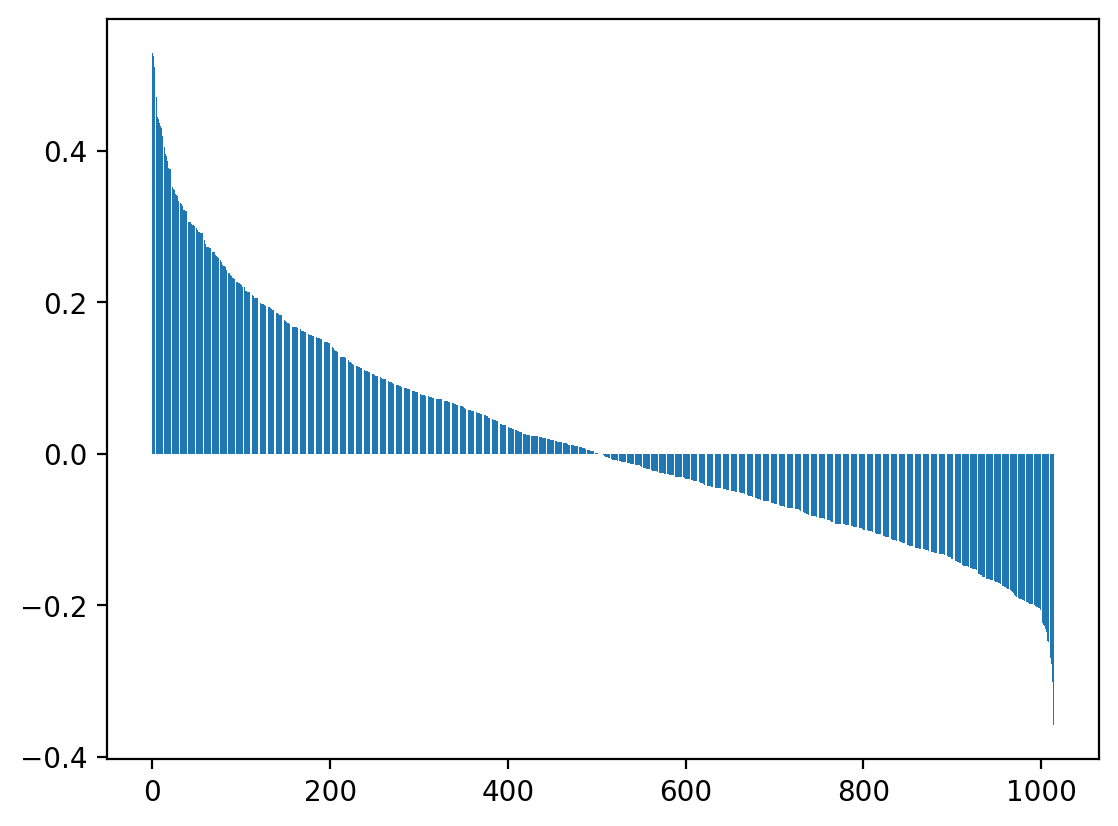

In [7]:
# Visualize the similarities
categories = list(range(len(sorted_similarities)))
fig, ax = plt.subplots()
ax.bar(categories, sorted_similarities)
plt.show()

In [14]:
# Compute probabilities
temperature = 0.055
logits = torch.Tensor([sim / temperature for sim in sorted_similarities])
probs = F.softmax(logits, dim=0)
list_probs = [probs[i].item() for i in range(len(probs))]

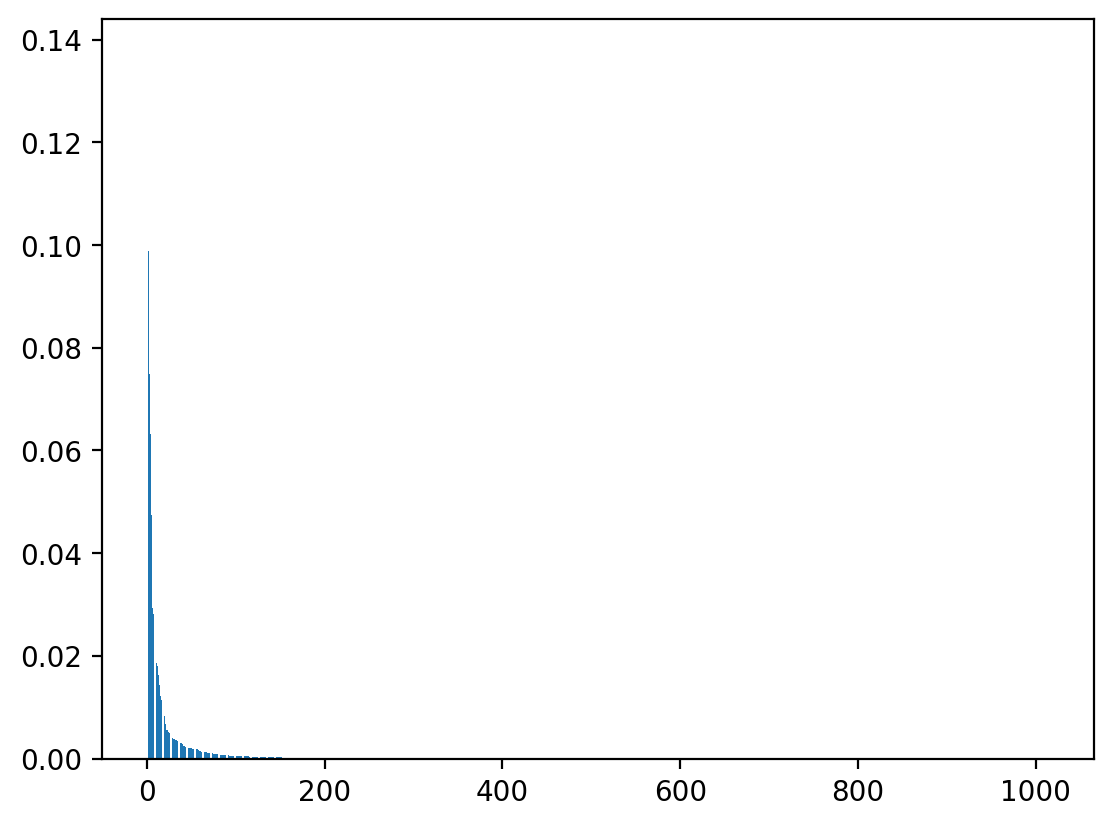

In [15]:
# Visualize the probabilities
categories = list(range(len(list_probs)))
fig, ax = plt.subplots()
ax.bar(categories, list_probs)
plt.show()

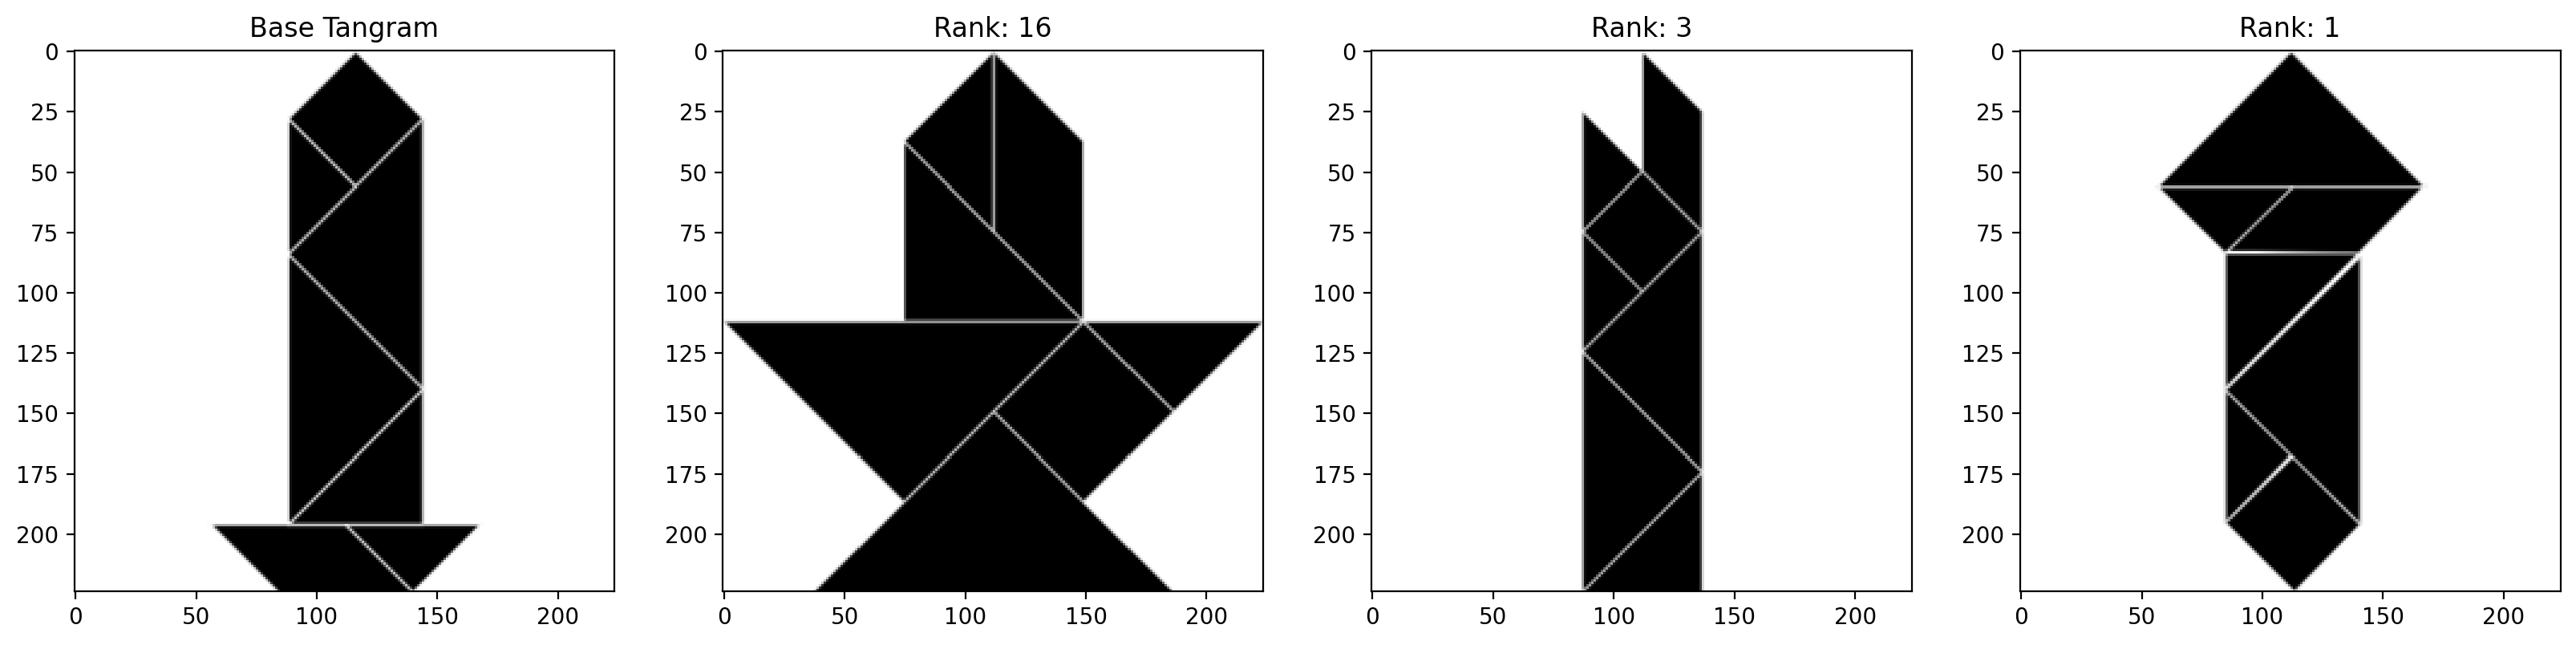

[16, 3, 1]


In [16]:
# Sample tangrams
samples = sample_without_replacement(probs, 3)

# Visualize the resulting context
context_tangrams = [base_tangram] + [sorted_tangrams[i] for i in samples]
context_tangrams = [t + ".png" for t in context_tangrams]

# Display everything
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 1

ax = []
for i in range(columns*rows):
    curr_tangram = context_tangrams[i]
    tangram_path = os.path.join(IMAGE_DIR, curr_tangram)
    img = Image.open(tangram_path).convert("RGB")
    ax.append(fig.add_subplot(rows, columns, i+1))

    if i == 0:
        title = "Base Tangram"
    else:
        title = f"Rank: {samples[i-1]}"
        
    ax[-1].set_title(title)  # set title

    plt.imshow(img)
    
plt.show()  # finally, render the plot
print(samples)

In [17]:
print(context_tangrams)

['page4-98.png', 'page1-137.png', 'page4-141.png', 'page2-174.png']


In [18]:
# Probability of sampling from top 30 most similar tangrams
print(f"Top 3 probabilities: {probs[0:3]}")
print(f"Probability of sampling from top 10: {torch.sum(probs[0:10])}")
print(f"Probability of sampling from top 30: {torch.sum(probs[0:30])}")
print(f"Probability of sampling from top 50: {torch.sum(probs[0:50])}")
print(f"Probability of sampling from top 100: {torch.sum(probs[0:100])}")

#print(f"Probability of sampling from bottom 500: {torch.sum(probs[-500:])}")

Top 3 probabilities: tensor([0.1371, 0.1288, 0.0988])
Probability of sampling from top 10: 0.656859278678894
Probability of sampling from top 30: 0.8515609502792358
Probability of sampling from top 50: 0.9083414077758789
Probability of sampling from top 100: 0.9621270895004272


In [52]:
top_3_probs = []
top_10_probs = []
top_30_probs = []
top_50_probs = []

# Get the base set of tangrams
split = "og_train"
all_tangrams = list(clip_model.keys())
if split in ["train", 'val', 'dev']:
    with open(os.path.join(SPLIT_DIR, f"{split}_imgs.pkl"), 'rb') as f:
        split_imgs = pickle.load(f)
    all_tangrams = [t for t in all_tangrams if t in split_imgs]
elif split == 'og_train':
    with open(os.path.join(SPLIT_DIR, f"train_imgs.pkl"), 'rb') as f:
        tr_imgs = pickle.load(f)
    with open(os.path.join(SPLIT_DIR, f"val_imgs.pkl"), 'rb') as f:
        val_imgs = pickle.load(f)
    split_imgs = tr_imgs + val_imgs
    all_tangrams = [t for t in all_tangrams if t in split_imgs]
    
for tangram in all_tangrams:
    # Get sorted similarities
    tangram_similarities = clip_model[tangram]
    sorted_similarities = sorted(tangram_similarities.items(), reverse=True, key=lambda x: x[1])
    sorted_similarities = [sim for sim in sorted_similarities if sim[0] in all_tangrams]
    sorted_tangrams = [sim[0] for sim in sorted_similarities]
    sorted_similarities = [sim[1] for sim in sorted_similarities]
    
    # Compute probabilities
    temperature = 0.055
    logits = torch.Tensor([sim / temperature for sim in sorted_similarities])
    probs = F.softmax(logits, dim=0)
    
    top_3_probs.append(torch.sum(probs[0:3]).item())
    top_10_probs.append(torch.sum(probs[0:10]).item())
    top_30_probs.append(torch.sum(probs[0:30]).item())
    top_50_probs.append(torch.sum(probs[0:50]).item())

In [53]:
import numpy as np

print(f"Average probability for sampling from the top 3: {np.mean(top_3_probs) * 100}")
print(f"Average probability for sampling from the top 10: {np.mean(top_10_probs) * 100}")
print(f"Average probability for sampling from the top 30: {np.mean(top_30_probs) * 100}")
print(f"Average probability for sampling from the top 50: {np.mean(top_50_probs) * 100}")
print()

print(f"Min probability for the top 10: {min(top_10_probs) * 100}")
print(f"Min probability for the top 30: {min(top_30_probs) * 100}")
print(f"Min probability for the top 50: {min(top_50_probs) * 100}")

Average probability for sampling from the top 3: 51.63074622006085
Average probability for sampling from the top 10: 72.36909312492162
Average probability for sampling from the top 30: 86.71134831760659
Average probability for sampling from the top 50: 91.42864736690687

Min probability for the top 10: 28.724676370620728
Min probability for the top 30: 48.637598752975464
Min probability for the top 50: 59.25548076629639


In [33]:
'''
All
Average probability for the top 10: 65.6859278678894
Average probability for the top 30: 85.15609502792358
Average probability for the top 50: 90.83414077758789

Train
Average probability for the top 10: 74.2155909538269
Average probability for the top 30: 88.69916796684265
Average probability for the top 50: 93.86364221572876

Dev
Average probability for the top 10: 84.9342942237854
Average probability for the top 30: 97.84306287765503
Average probability for the top 50: 99.32295083999634
'''

'\nAll\nAverage probability for the top 10: 65.6859278678894\nAverage probability for the top 30: 85.15609502792358\nAverage probability for the top 50: 90.83414077758789\n\nTrain\nAverage probability for the top 10: 74.2155909538269\nAverage probability for the top 30: 88.69916796684265\nAverage probability for the top 50: 93.86364221572876\n\nDev\nAverage probability for the top 10: 84.9342942237854\nAverage probability for the top 30: 97.84306287765503\nAverage probability for the top 50: 99.32295083999634\n'